In [ ]:
%fs
ls "/mnt/amldata1"


path,name,size,modificationTime
dbfs:/mnt/amldata1/models/,models/,0,1723378296000
dbfs:/mnt/amldata1/raw_data/,raw_data/,0,1722704148000
dbfs:/mnt/amldata1/transformed_data/,transformed_data/,0,1722704165000


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, regexp_replace, to_date
from pyspark.ml.feature import StringIndexer

# Initialize Spark session
spark = SparkSession.builder \
    .appName("Data Processing and Cleaning") \
    .getOrCreate()

# Load data (assuming you have already read your data into 'df')
df = spark.read.csv("/mnt/amldata1/raw_data/dataset.csv", header=True, inferSchema=True)

df.show()


+----------------+---------+----------------+---------+----------------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank|         Account|  To Bank|       Account.1|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+----------------+---------+----------------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/14 14:25|  22483.0|3.96198008724E11|2122502.0|6.85224370921E11|       13839.26|              Euro|   13839.26|            Euro|   Credit Card|          0.0|
|2022/09/06 19:37| 110968.0|6.91975356951E11| 286299.0|1.14086851699E11|         637.56|         US Dollar|     637.56|       US Dollar|        Cheque|          0.0|
|2022/09/14 01:58|     70.0|  9.792510395E11| 283504.0|9.55692521826E11|         153.17|         US Dollar|     153.17|       US Dollar|          Cash|          0.0|
|202

In [ ]:
# Assuming df is your DataFrame
columns_list = df.columns

# Print the list of columns
print(columns_list)


['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Receiving Currency', 'Amount Paid', 'Payment Currency', 'Payment Format', 'Is Laundering']


In [ ]:
from pyspark.sql.functions import col, sum

# Count null values for each column
null_counts = df.select([sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])

# Show the result
null_counts.show()


In [ ]:
# Step 1: Data Cleaning

df = df.na.drop(subset=['From Bank', 'Payment Format'])

In [ ]:
# 1.2 Remove Duplicates
df = df.dropDuplicates()

In [ ]:
#df is our DataFrame
columns_and_types = df.dtypes

# Print the data types of all columns
for column, data_type in columns_and_types:
    print(f"Column: {column}, Data Type: {data_type}")


Column: Timestamp, Data Type: string
Column: From Bank, Data Type: double
Column: Account, Data Type: double
Column: To Bank, Data Type: double
Column: Account.1, Data Type: double
Column: Amount Received, Data Type: double
Column: Receiving Currency, Data Type: string
Column: Amount Paid, Data Type: double
Column: Payment Currency, Data Type: string
Column: Payment Format, Data Type: string
Column: Is Laundering, Data Type: double


In [ ]:
# 1.3 Data Type Transformation
df = df.withColumn("Timestamp", to_date(col("Timestamp"), "yyyy-MM-dd"))

In [ ]:
from pyspark.sql.functions import year, month

# Add 'Year' column extracted from 'Timestamp'
data = data.withColumn('Year', year('Timestamp'))

# Add 'Month' column extracted from 'Timestamp'
data = data.withColumn('Month', month('Timestamp'))


In [ ]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
indexer = StringIndexer(inputCol="Payment Format", outputCol="Payment Format Index")

# Fit the indexer and transform the data
df_indexed = indexer.fit(df).transform(df)

# Show the resulting DataFrame with the new indexed column
df_indexed.select("Payment Format", "Payment Format Index").show()


+--------------+--------------------+
|Payment Format|Payment Format Index|
+--------------+--------------------+
|           ACH|                 1.0|
|          Wire|                 5.0|
|   Credit Card|                 2.0|
|   Credit Card|                 2.0|
|        Cheque|                 0.0|
|        Cheque|                 0.0|
|          Cash|                 3.0|
|        Cheque|                 0.0|
|           ACH|                 1.0|
|   Credit Card|                 2.0|
|        Cheque|                 0.0|
|   Credit Card|                 2.0|
|   Credit Card|                 2.0|
|   Credit Card|                 2.0|
|   Credit Card|                 2.0|
|   Credit Card|                 2.0|
|        Cheque|                 0.0|
|        Cheque|                 0.0|
|        Cheque|                 0.0|
|   Credit Card|                 2.0|
+--------------+--------------------+
only showing top 20 rows



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor


In [ ]:
# Define the path to your CSV file
file_path = "/mnt/amldata1/raw_data/dataset.csv"

# Read the CSV file into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert Spark DataFrame to pandas DataFrame
data = df.toPandas()

# Show the data
data.head(5)



,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
0,2022/09/14 14:25,22483.0,3.961980e+11,2122502.0,6.852244e+11,13839.26,Euro,13839.26,Euro,Credit Card,0.0
1,2022/09/06 19:37,110968.0,6.919754e+11,286299.0,1.140869e+11,637.56,US Dollar,637.56,US Dollar,Cheque,0.0
2,2022/09/14 01:58,70.0,9.792510e+11,283504.0,9.556925e+11,153.17,US Dollar,153.17,US Dollar,Cash,0.0
3,2022/09/07 16:28,25.0,7.145868e+11,130142.0,9.409780e+11,14724.68,Yuan,14724.68,Yuan,Credit Card,0.0
4,2022/09/09 22:22,1315.0,1.605006e+11,122138.0,3.288542e+11,50080.79,US Dollar,50080.79,US Dollar,Cheque,0.0


In [ ]:
data.tail()

,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering
1247266,2022/09/18 10:49,3.0,2.314647e+11,231646.0,1.944843e+11,18452.14,US Dollar,18452.14,US Dollar,ACH,1.0
1247267,2022/09/21 11:20,231646.0,5.773843e+11,28920.0,9.383246e+11,20180.27,US Dollar,20180.27,US Dollar,ACH,1.0
1247268,2022/09/19 12:56,28920.0,2.706355e+11,237063.0,6.453592e+11,19430.22,US Dollar,19430.22,US Dollar,ACH,1.0
1247269,2022/09/22 09:09,237063.0,5.314594e+11,192738.0,9.177097e+11,14808.76,UK Pound,14808.76,UK Pound,ACH,1.0
1247270,2022/09/18 16:41,192738.0,7.724497e+11,21954.0,1.632963e+11,18022.26,Euro,18022.26,Euro,ACH,1.0


In [ ]:
data.shape

(1247271, 11)

In [ ]:
data.columns

Index(['Timestamp', 'From Bank', 'Account', 'To Bank', 'Account.1',
       'Amount Received', 'Receiving Currency', 'Amount Paid',
       'Payment Currency', 'Payment Format', 'Is Laundering'],
      dtype='object')

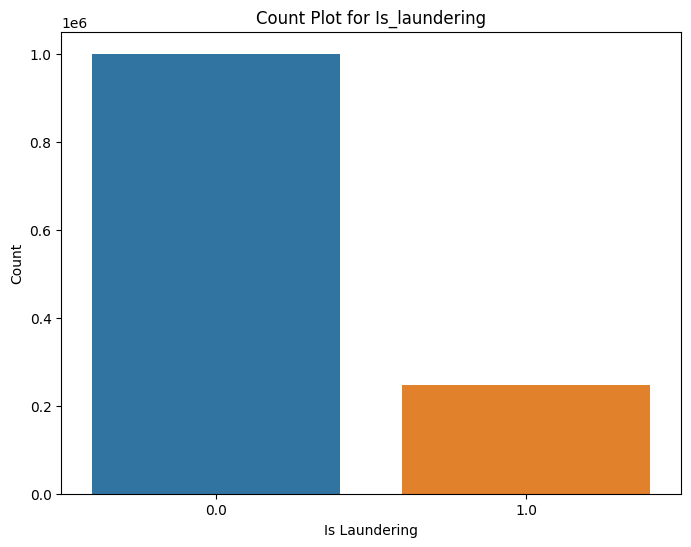

In [ ]:
# Plot the count plot
plt.figure(figsize=(8, 6))
sns.countplot(x='Is Laundering', data=data)
plt.title('Count Plot for Is_laundering')  # Correct method for setting the title
plt.xlabel('Is Laundering')  # Correct method for setting the x-axis label
plt.ylabel('Count')  # Correct method for setting the y-axis label
plt.show()


In [ ]:
counts = data['Is Laundering'].value_counts()
print(counts)

0.0    1000000
1.0     247271
Name: Is Laundering, dtype: int64


In [ ]:
data['Timestamp'] = pd.to_datetime(data['Timestamp'])

In [ ]:
data['Year'] = data['Timestamp'].dt.year
data['Month'] = data['Timestamp'].dt.month



In [ ]:
data = data.drop(columns=['Timestamp'])

In [ ]:
data.head()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month
0,22483.0,3.961980e+11,2122502.0,6.852244e+11,13839.26,Euro,13839.26,Euro,Credit Card,0.0,2022.0,9.0
1,110968.0,6.919754e+11,286299.0,1.140869e+11,637.56,US Dollar,637.56,US Dollar,Cheque,0.0,2022.0,9.0
2,70.0,9.792510e+11,283504.0,9.556925e+11,153.17,US Dollar,153.17,US Dollar,Cash,0.0,2022.0,9.0
3,25.0,7.145868e+11,130142.0,9.409780e+11,14724.68,Yuan,14724.68,Yuan,Credit Card,0.0,2022.0,9.0
4,1315.0,1.605006e+11,122138.0,3.288542e+11,50080.79,US Dollar,50080.79,US Dollar,Cheque,0.0,2022.0,9.0


In [ ]:
data.tail()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month
1247266,3.0,2.314647e+11,231646.0,1.944843e+11,18452.14,US Dollar,18452.14,US Dollar,ACH,1.0,2022.0,9.0
1247267,231646.0,5.773843e+11,28920.0,9.383246e+11,20180.27,US Dollar,20180.27,US Dollar,ACH,1.0,2022.0,9.0
1247268,28920.0,2.706355e+11,237063.0,6.453592e+11,19430.22,US Dollar,19430.22,US Dollar,ACH,1.0,2022.0,9.0
1247269,237063.0,5.314594e+11,192738.0,9.177097e+11,14808.76,UK Pound,14808.76,UK Pound,ACH,1.0,2022.0,9.0
1247270,192738.0,7.724497e+11,21954.0,1.632963e+11,18022.26,Euro,18022.26,Euro,ACH,1.0,2022.0,9.0


In [ ]:
data['Year'].nunique()

2

In [ ]:
data['Month'].nunique()

6

In [ ]:
data['Payment Currency'].nunique()

15

In [ ]:
data['Payment Format'].nunique()

7

In [ ]:
# Number of unique values in 'Payment Format'
num_unique_values = data['Payment Format'].nunique()
print(f"Number of unique values: {num_unique_values}")

# Unique values in 'Payment Format'
unique_values = data['Payment Format'].unique()
print(f"Unique values: {unique_values}")


Number of unique values: 7
Unique values: ['Credit Card' 'Cheque' 'Cash' 'ACH' 'Wire' 'Reinvestment' 'Bitcoin']


In [ ]:
data['Receiving Currency'].nunique()

15

In [ ]:
data['Payment Currency'].nunique()

15

In [ ]:
# Number of unique values in 'Payment Currency'
num_unique_values = data['Payment Currency'].nunique()
print(f"Number of unique values: {num_unique_values}")

# Unique values in 'Payment Currency'
unique_values = data['Payment Currency'].unique()
print(f"Unique values: {unique_values}")


Number of unique values: 15
Unique values: ['Euro' 'US Dollar' 'Yuan' 'Yen' 'Rupee' 'Brazil Real' 'Mexican Peso'
 'Shekel' 'Bitcoin' 'Ruble' 'Swiss Franc' 'UK Pound' 'Australian Dollar'
 'Saudi Riyal' 'Canadian Dollar' None]


In [ ]:
data.isnull().sum()

From Bank              200
Account                450
To Bank                100
Account.1              175
Amount Received         45
Receiving Currency    1200
Amount Paid           1350
Payment Currency       800
Payment Format           0
Is Laundering            0
Year                   700
Month                  700
dtype: int64

In [ ]:
data = data.dropna()

In [ ]:
data.isnull().sum()

From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
Year                  0
Month                 0
dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1242260 entries, 0 to 1247270
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   From Bank           1242260 non-null  float64
 1   Account             1242260 non-null  float64
 2   To Bank             1242260 non-null  float64
 3   Account.1           1242260 non-null  float64
 4   Amount Received     1242260 non-null  float64
 5   Receiving Currency  1242260 non-null  object 
 6   Amount Paid         1242260 non-null  float64
 7   Payment Currency    1242260 non-null  object 
 8   Payment Format      1242260 non-null  object 
 9   Is Laundering       1242260 non-null  float64
 10  Year                1242260 non-null  float64
 11  Month               1242260 non-null  float64
dtypes: float64(9), object(3)
memory usage: 123.2+ MB


In [ ]:
# Identify numerical variables in the dataset
num_vars = data.select_dtypes(include=['number']).columns.tolist()

# Print the list of numerical variables
print("Numerical Variables:", num_vars)


Numerical Variables: ['From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received', 'Amount Paid', 'Is Laundering', 'Year', 'Month']


In [ ]:
# Identify categorical variables in the dataset
cat_vars = data.select_dtypes(include=['object', 'category']).columns.tolist()

# Print the list of categorical variables
print("Categorical Variables:", cat_vars)

Categorical Variables: ['Receiving Currency', 'Payment Currency', 'Payment Format']


In [ ]:
# Encode categorical features
label_encoders = {}
for feature in cat_vars:
  le = LabelEncoder()
  data[feature] = le.fit_transform(data[feature])
  label_encoders[feature] = le

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Define features and target variable
X = data[['From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received',
          'Amount Paid', 'Year', 'Month']]
y = data['Is Laundering']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# List of numerical variables (excluding the target variable)
num_vars = ['From Bank', 'Account', 'To Bank', 'Account.1', 'Amount Received',
            'Amount Paid', 'Year', 'Month', 'Day']

# Ensure the columns exist in the DataFrame
num_vars_train = [col for col in num_vars if col in X_train.columns]
num_vars_test = [col for col in num_vars if col in X_test.columns]

# Initialize the scaler
scaler = StandardScaler()

# Standardize numerical features present in both X_train and X_test
if num_vars_train:
    X_train[num_vars_train] = scaler.fit_transform(X_train[num_vars_train])
if num_vars_test:
    X_test[num_vars_test] = scaler.transform(X_test[num_vars_test])

# Display the first few rows of the standardized training data
print(X_train.head())


         From Bank   Account   To Bank  ...  Amount Paid      Year     Month
414484   -0.424917  0.847065 -0.256784  ...    -0.003898 -0.011827 -0.183553
283252   -0.207499  0.798564 -0.491576  ...    -0.003898 -0.011827 -0.183553
364698   -0.011783  0.948760  3.381191  ...    -0.003898 -0.011827 -0.183553
1158049  -0.404236 -0.100471 -0.489027  ...    -0.003898 -0.011827  2.084938
1170099  -0.375775 -0.574586 -0.519038  ...    -0.003898 -0.011827  2.084938

[5 rows x 8 columns]


In [ ]:
import pickle
# Save the label encoders to a pickle file
with open('label_encoders.pkl', 'wb') as f:
    pickle.dump(label_encoders, f)

print("Label encoders have been saved to 'label_encoders.pkl'")


Label encoders have been saved to 'label_encoders.pkl'


In [ ]:
import pickle

# Save the scaler to a pickle file
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Scaler has been saved to 'scaler.pkl'")


Scaler has been saved to 'scaler.pkl'


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1242260 entries, 0 to 1247270
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   From Bank           1242260 non-null  float64
 1   Account             1242260 non-null  float64
 2   To Bank             1242260 non-null  float64
 3   Account.1           1242260 non-null  float64
 4   Amount Received     1242260 non-null  float64
 5   Receiving Currency  1242260 non-null  int64  
 6   Amount Paid         1242260 non-null  float64
 7   Payment Currency    1242260 non-null  int64  
 8   Payment Format      1242260 non-null  int64  
 9   Is Laundering       1242260 non-null  float64
 10  Year                1242260 non-null  float64
 11  Month               1242260 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 123.2 MB


In [ ]:
data.head()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month
0,22483.0,3.961980e+11,2122502.0,6.852244e+11,13839.26,4,13839.26,4,4,0.0,2022.0,9.0
1,110968.0,6.919754e+11,286299.0,1.140869e+11,637.56,12,637.56,12,3,0.0,2022.0,9.0
2,70.0,9.792510e+11,283504.0,9.556925e+11,153.17,12,153.17,12,2,0.0,2022.0,9.0
3,25.0,7.145868e+11,130142.0,9.409780e+11,14724.68,14,14724.68,14,4,0.0,2022.0,9.0
4,1315.0,1.605006e+11,122138.0,3.288542e+11,50080.79,12,50080.79,12,3,0.0,2022.0,9.0


In [ ]:
data.shape

(1242260, 12)

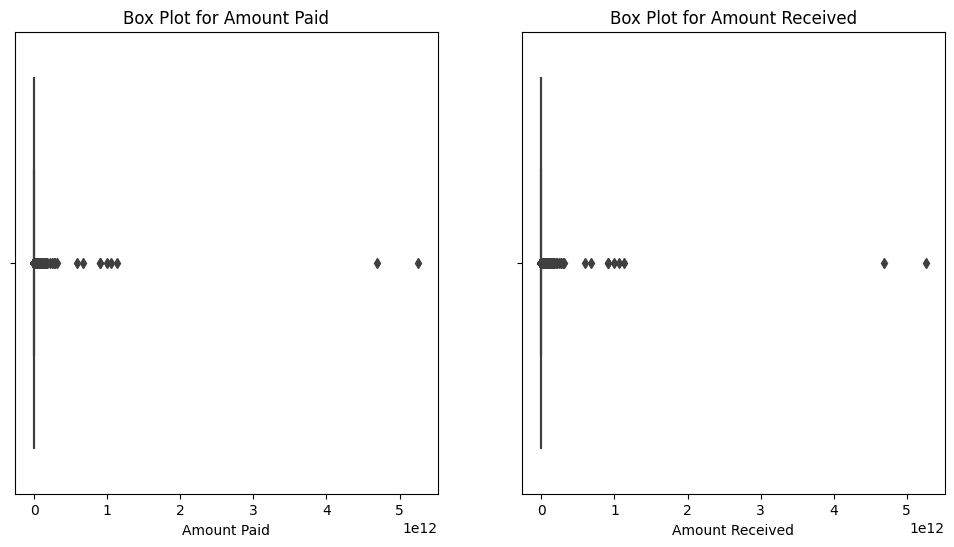

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x=data['Amount Paid'])
plt.title('Box Plot for Amount Paid')

plt.subplot(1, 2, 2)
sns.boxplot(x=data['Amount Received'])
plt.title('Box Plot for Amount Received')

plt.show()

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

X = data[['Amount Received', 'Amount Paid', 'Payment Format','Year','Month','Receiving Currency','Payment Currency']]
y = data['Is Laundering']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Apply under-sampling
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

# Now, X_train_resampled and y_train_resampled are balanced

In [ ]:
data.head()

,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,Year,Month
0,22483.0,3.961980e+11,2122502.0,6.852244e+11,13839.26,4,13839.26,4,4,0.0,2022.0,9.0
1,110968.0,6.919754e+11,286299.0,1.140869e+11,637.56,12,637.56,12,3,0.0,2022.0,9.0
2,70.0,9.792510e+11,283504.0,9.556925e+11,153.17,12,153.17,12,2,0.0,2022.0,9.0
3,25.0,7.145868e+11,130142.0,9.409780e+11,14724.68,14,14724.68,14,4,0.0,2022.0,9.0
4,1315.0,1.605006e+11,122138.0,3.288542e+11,50080.79,12,50080.79,12,3,0.0,2022.0,9.0


In [ ]:
data['Receiving Currency'].unique()

array([ 4, 12, 14, 13,  7,  2,  5,  9,  1,  6, 10, 11,  0,  8,  3])

In [ ]:
from sklearn.preprocessing import StandardScaler

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply standardization to 'Amount Received' and 'Amount Paid' columns
data[['Amount Received', 'Amount Paid']] = scaler.fit_transform(data[['Amount Received', 'Amount Paid']])

# Now data has the standardized 'Amount Received' and 'Amount Paid' columns


In [ ]:
data.dtypes

From Bank             float64
Account               float64
To Bank               float64
Account.1             float64
Amount Received       float64
Receiving Currency      int64
Amount Paid           float64
Payment Currency        int64
Payment Format          int64
Is Laundering         float64
Year                  float64
Month                 float64
dtype: object

In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
From Bank,1242260.0,2.213140e+05,5.203824e+05,0.000000e+00,1.994000e+03,2.670400e+04,1.872640e+05,3.225444e+06
Account,1242260.0,5.632118e+11,2.643637e+11,1.000003e+11,3.335457e+11,5.678679e+11,7.907024e+11,9.999989e+11
To Bank,1242260.0,3.047346e+05,5.642355e+05,0.000000e+00,1.808100e+04,1.181590e+05,2.256640e+05,3.224991e+06
Account.1,1242260.0,5.501964e+11,2.598592e+11,1.000001e+11,3.250580e+11,5.504987e+11,7.755970e+11,9.999996e+11
Amount Received,1242260.0,-7.206896e-19,1.000000e+00,-3.549057e-03,-3.549010e-03,-3.548656e-03,-3.546822e-03,7.791197e+02
Receiving Currency,1242260.0,8.466485e+00,4.213789e+00,0.000000e+00,4.000000e+00,1.100000e+01,1.200000e+01,1.400000e+01
Amount Paid,1242260.0,4.747400e-19,1.000000e+00,-3.396995e-03,-3.396948e-03,-3.396594e-03,-3.394764e-03,7.800806e+02
Payment Currency,1242260.0,8.489498e+00,4.212017e+00,0.000000e+00,4.000000e+00,1.100000e+01,1.200000e+01,1.400000e+01
Payment Format,1242260.0,2.435311e+00,1.760477e+00,0.000000e+00,0.000000e+00,3.000000e+00,4.000000e+00,6.000000e+00
Is Laundering,1242260.0,1.982580e-01,3.986877e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


In [ ]:
# plt.figure(figsize=(13,17))
# sns.pairplot(data=data.drop(['Amount Received','Amount Paid'],axis=1))
# plt.show()

Is Laundering
0.0    [[Axes(0.125,0.722857;0.215278x0.157143), Axes...
1.0    [[Axes(0.125,0.722857;0.215278x0.157143), Axes...
dtype: object

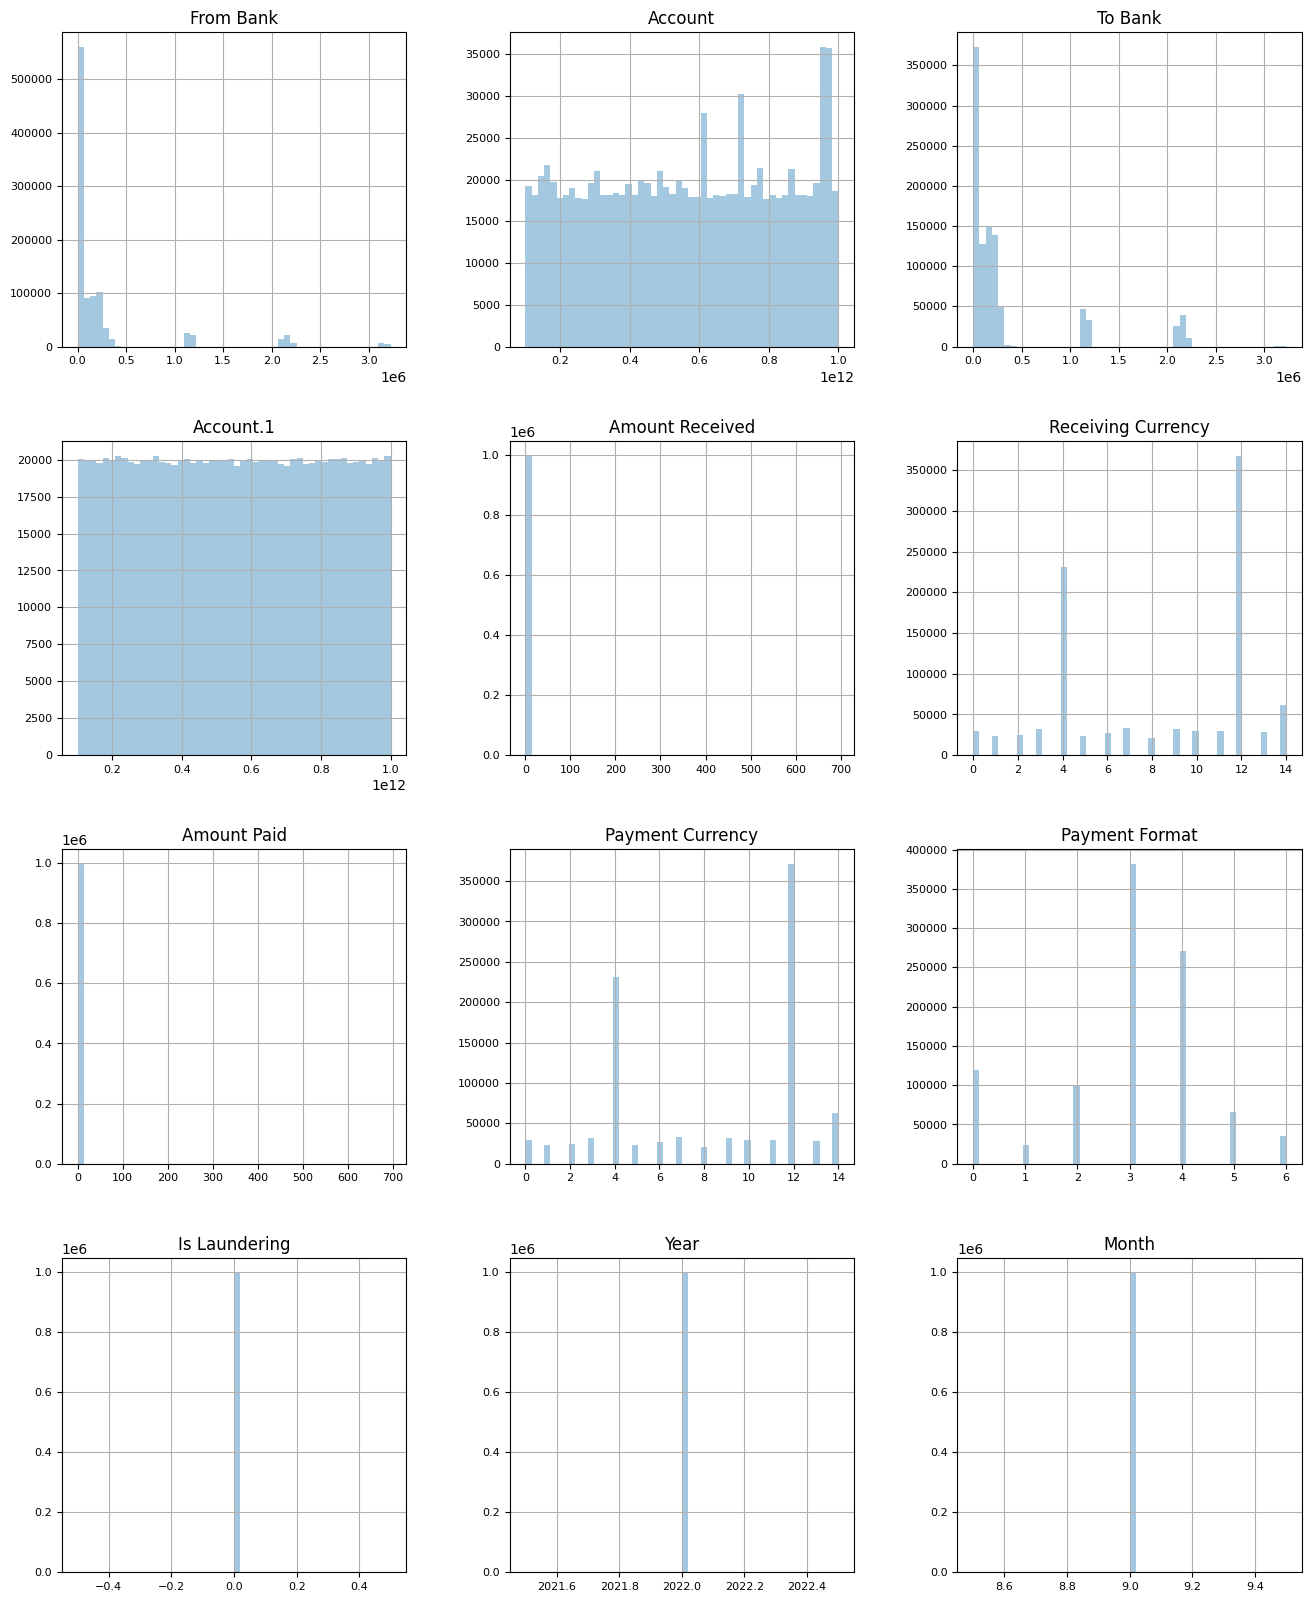

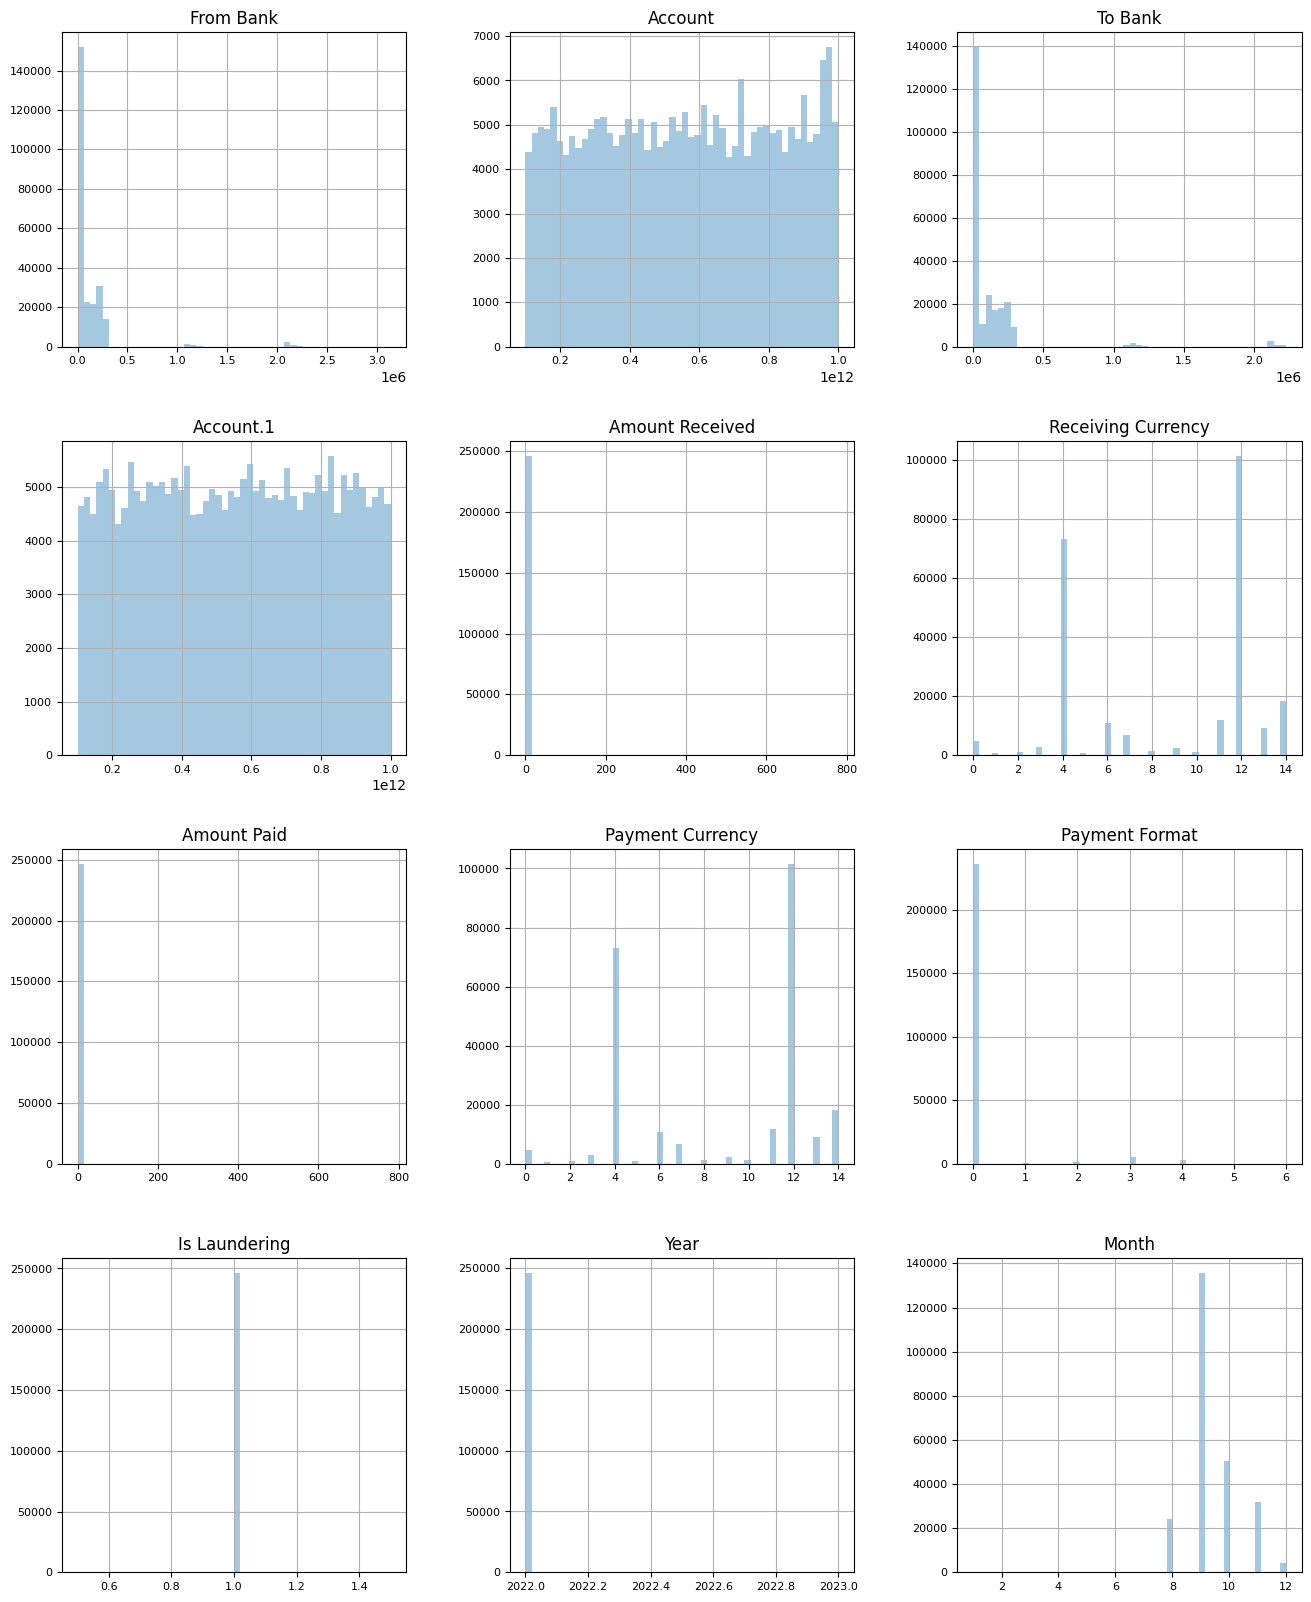

In [ ]:
''' Visualising the variables by grouping them by class '''

data.groupby('Is Laundering').hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8,alpha=0.4)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1242260 entries, 0 to 1247270
Data columns (total 12 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   From Bank           1242260 non-null  float64
 1   Account             1242260 non-null  float64
 2   To Bank             1242260 non-null  float64
 3   Account.1           1242260 non-null  float64
 4   Amount Received     1242260 non-null  float64
 5   Receiving Currency  1242260 non-null  int64  
 6   Amount Paid         1242260 non-null  float64
 7   Payment Currency    1242260 non-null  int64  
 8   Payment Format      1242260 non-null  int64  
 9   Is Laundering       1242260 non-null  float64
 10  Year                1242260 non-null  float64
 11  Month               1242260 non-null  float64
dtypes: float64(9), int64(3)
memory usage: 123.2 MB


<Axes: title={'center': 'Correlation Matrix'}>

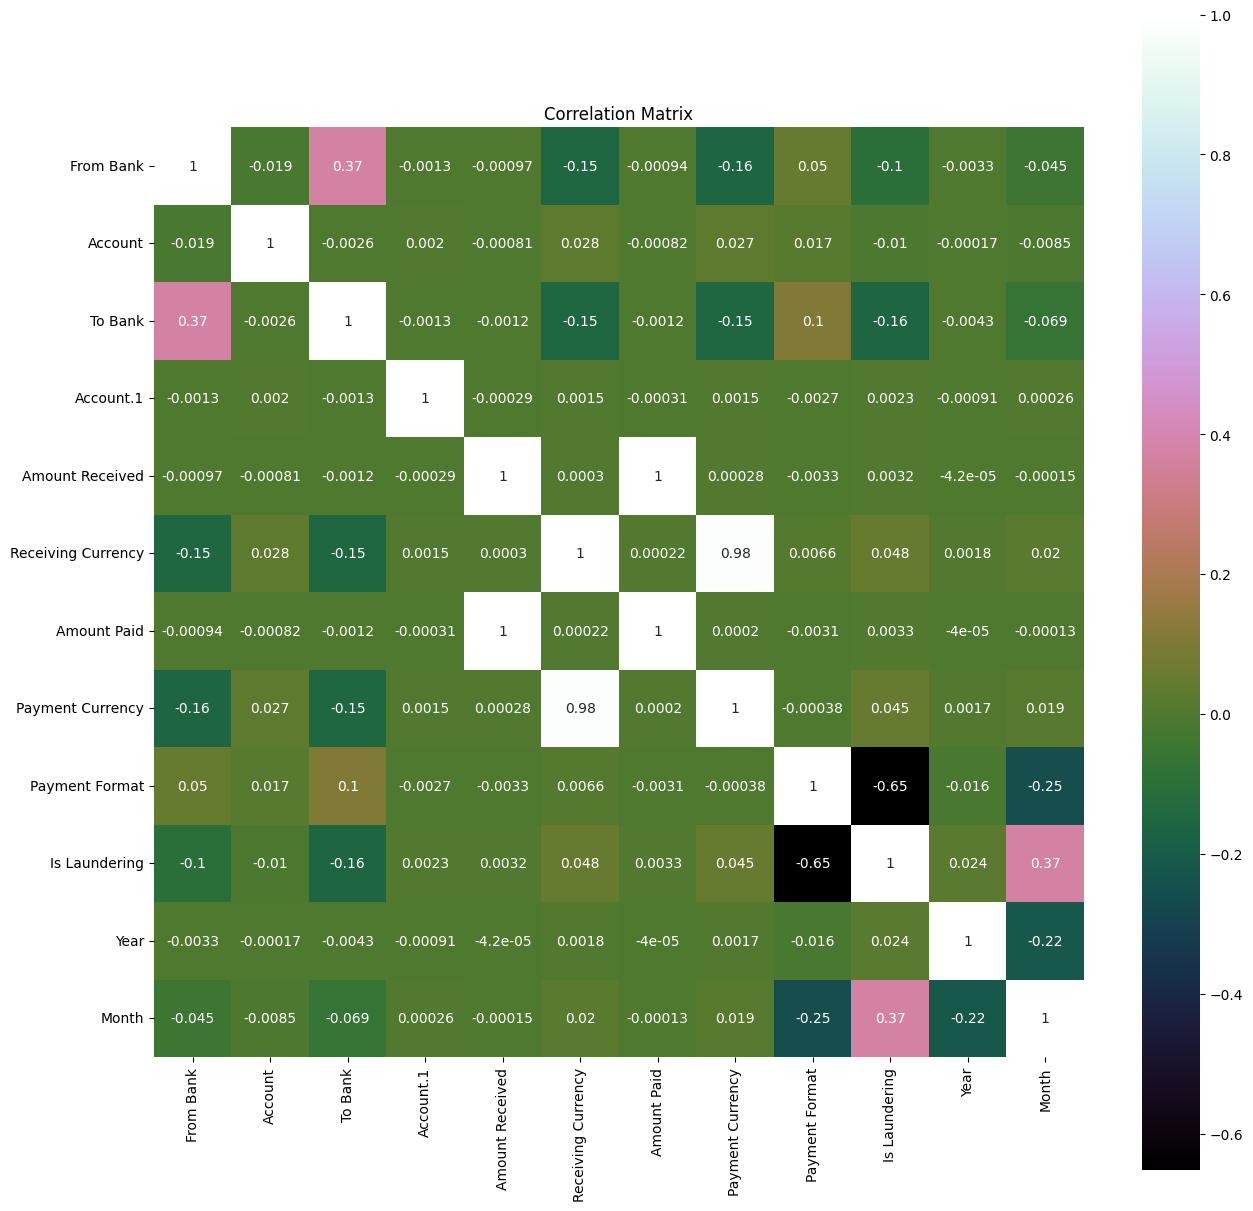

In [ ]:
''' correlation matrix to check multicolinearity between variables '''

correlation = data.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')


**Model Building**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# Features and target variable
X = data[['Amount Received', 'Amount Paid', 'Payment Format','Year','Month']]
y = data['Is Laundering']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Random Forest Classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [ ]:
# Predictions
y_pred = rf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)

Accuracy: 0.8960765057234396
Confusion Matrix:
[[198114    994]
 [ 24826  24518]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.89      1.00      0.94    199108
         1.0       0.96      0.50      0.66     49344

    accuracy                           0.90    248452
   macro avg       0.92      0.75      0.80    248452
weighted avg       0.90      0.90      0.88    248452



In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


X = data[['Amount Received', 'Amount Paid', 'Payment Format','Year','Month']]
y = data['Is Laundering']
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Logistic Regression model
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg.predict(X_test)



In [ ]:
data.isna().sum()

From Bank             0
Account               0
To Bank               0
Account.1             0
Amount Received       0
Receiving Currency    0
Amount Paid           0
Payment Currency      0
Payment Format        0
Is Laundering         0
Year                  0
Month                 0
dtype: int64

In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(class_report)


Accuracy: 0.8762457134577303
Confusion Matrix:
[[175302  23806]
 [  6941  42403]]
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92    199108
         1.0       0.64      0.86      0.73     49344

    accuracy                           0.88    248452
   macro avg       0.80      0.87      0.83    248452
weighted avg       0.90      0.88      0.88    248452



In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier  # Use XGBRegressor for regression tasks

# Assuming data is your DataFrame and you have done the encoding and imputation

# Assuming 'target_column' is the name of the column you want to predict
X = data[['Amount Received', 'Amount Paid', 'Payment Format','Year','Month','Receiving Currency','Payment Currency']]
y = data['Is Laundering']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the XGBoost model
model = XGBClassifier()  # Use XGBRegressor() if it's a regression problem
model.fit(X_train, y_train)

# Evaluate the model (optional)
accuracy = model.score(X_test, y_test)
print(f"Model Accuracy: {accuracy:.2f}")

# Make predictions (optional)
# predictions = model.predict(X_test)


Model Accuracy: 0.95


In [ ]:
# Save the model to a pickle file
with open('xgb_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("XGBoost model has been saved to 'xgb_model.pkl'")

XGBoost model has been saved to 'xgb_model.pkl'


In [ ]:
import joblib
from azure.storage.blob import BlobServiceClient

# Path to save the model locally first
local_model_path = "/dbfs/mnt/models/random_forest_model.joblib"

# Save the model locally
joblib.dump(rf, local_model_path)

# Save the model to Azure Blob Storage
blob_service_client = BlobServiceClient.from_connection_string("DefaultEndpointsProtocol=https;AccountName=amldatacnak;AccountKey=OD7x5wWUM2IoaFIUIVW1Sq8hI6HzKhnA7Rr4nI+9/OH0jElAD+eksiEoIsIyhjmSlgoynvE5cUwa+AStSBrKkQ==;EndpointSuffix=core.windows.net")
container_name = "amldata"
blob_client = blob_service_client.get_blob_client(container=container_name, blob="models/random_forest_model.joblib")

with open(local_model_path, "rb") as data:
    blob_client.upload_blob(data)


In [ ]:
import joblib
from sklearn.preprocessing import LabelEncoder
import os

# Assuming you have access to the original training data
# Load your training data
# training_data = pd.read_csv('path_to_your_training_data.csv')
file_path = "/mnt/amldata1/raw_data/dataset.csv"
df1 = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert Spark DataFrame to pandas DataFrame
df2 = df1.toPandas()
# Define the categorical features
categorical_features = ['Payment Format']  # Add your actual categorical columns

# Create and fit the label encoders
label_encoders = {}
for feature in categorical_features:
    encoder = LabelEncoder()
    label_encoders[feature] = encoder.fit(df2[feature].astype(str))

# Save the encoders to a file
os.makedirs('/dbfs/mnt/', exist_ok=True)
joblib.dump(label_encoders, '/dbfs/mnt/label_encoders.joblib')

# You can now upload this file to Azure Blob Storage
from azure.storage.blob import BlobServiceClient

# Initialize BlobServiceClient
connection_string = "DefaultEndpointsProtocol=https;AccountName=amldatacnak;AccountKey=OD7x5wWUM2IoaFIUIVW1Sq8hI6HzKhnA7Rr4nI+9/OH0jElAD+eksiEoIsIyhjmSlgoynvE5cUwa+AStSBrKkQ==;EndpointSuffix=core.windows.net"
container_name = "amldata"

# Initialize BlobServiceClient
blob_service_client = BlobServiceClient.from_connection_string(connection_string)


# Upload the label encoders to Azure Blob Storage
label_encoders_blob_path = "models/label_encoders.joblib"
label_encoders_blob_client = blob_service_client.get_blob_client(container=container_name, blob=label_encoders_blob_path)

with open('/dbfs/mnt/label_encoders.joblib', "rb") as enc_file:
    label_encoders_blob_client.upload_blob(enc_file, overwrite=True)
